# Work With Standardized Spectral File For ESSP4
Standardized spectra have filenames of the form: `DS#.###_spec_<<inst>>.fits`

For example, the twelfth (012) observation from data set three (3), taken by the HARPS-N instrument will have the file name: `DS3.012_spec_harpsn.fits`

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
import seaborn as sns

In [2]:
# Specify file name
# (I'll select a random file from a specified data set)

# Specify where all the data set folders (i.e. DS1) are, here saved into "essp_dir" variable
essp_dir = "/work2/lbuc/data/ESSP4/ESSP4"

# Specify data set number
dset_num = 1

# Select a file at random from all files in the data set
file_list = glob(os.path.join(essp_dir,f'DS{dset_num}','CCFs',f'DS{dset_num}*.fits'))
file_name = np.random.choice(file_list)

In [3]:
hdus = fits.open(file_name)
hdus.info()

Filename: /work2/lbuc/data/ESSP4/ESSP4/DS1/CCFs/DS1.222_ccfs_neid.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   ()      
  1  V_GRID        1 ImageHDU         7   (61,)   float64   
  2  CCF           1 ImageHDU         7   (61,)   float64   
  3  E_CCF         1 ImageHDU         7   (61,)   float64   
  4  ECHELLE_ORDERS    1 ImageHDU         7   (93,)   int64   
  5  OBO_CCF       1 ImageHDU         8   (61, 93)   float64   
  6  OBO_E_CCF     1 ImageHDU         8   (61, 93)   float64   
  7  OBO_RV        1 ImageHDU         7   (93,)   float64   
  8  OBO_E_RV      1 ImageHDU         7   (93,)   float64   


## Plot CCF and Order-by-Order (`obo`) CCFs

[-1.2000000e+01 -1.1600000e+01 -1.1200000e+01 -1.0800000e+01
 -1.0400000e+01 -1.0000000e+01 -9.6000000e+00 -9.2000000e+00
 -8.8000000e+00 -8.4000000e+00 -8.0000000e+00 -7.6000000e+00
 -7.2000000e+00 -6.8000000e+00 -6.4000000e+00 -6.0000000e+00
 -5.6000000e+00 -5.2000000e+00 -4.8000000e+00 -4.4000000e+00
 -4.0000000e+00 -3.6000000e+00 -3.2000000e+00 -2.8000000e+00
 -2.4000000e+00 -2.0000000e+00 -1.6000000e+00 -1.2000000e+00
 -8.0000000e-01 -4.0000000e-01  1.0658141e-14  4.0000000e-01
  8.0000000e-01  1.2000000e+00  1.6000000e+00  2.0000000e+00
  2.4000000e+00  2.8000000e+00  3.2000000e+00  3.6000000e+00
  4.0000000e+00  4.4000000e+00  4.8000000e+00  5.2000000e+00
  5.6000000e+00  6.0000000e+00  6.4000000e+00  6.8000000e+00
  7.2000000e+00  7.6000000e+00  8.0000000e+00  8.4000000e+00
  8.8000000e+00  9.2000000e+00  9.6000000e+00  1.0000000e+01
  1.0400000e+01  1.0800000e+01  1.1200000e+01  1.1600000e+01
  1.2000000e+01]
[-1.2000000e+01 -1.1600000e+01 -1.1200000e+01 -1.0800000e+01
 -1.040

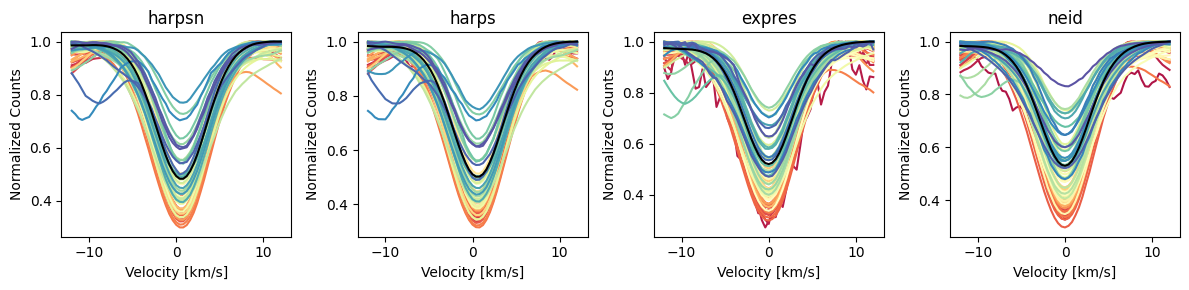

In [12]:
fig, axes = plt.subplots(1,4,figsize=(12,3))
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    ax = axes[iinst]
    ax.set_title(inst)
    ax.set_xlabel('Velocity [km/s]')
    ax.set_ylabel('Normalized Counts')
    # Select a random file
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','CCFs',f'DS{dset_num}*_{inst}.fits')))
    
    # Read in data
    hdus = fits.open(file)
    num_ord = len(hdus['echelle_orders'].data) # number of orders
    colors = sns.color_palette('Spectral',num_ord) # use that to define a color map
    v_grid = hdus['v_grid'].data.copy() # velocity grid for all CCFs in the file
    print(v_grid)
    ccf = hdus['ccf'].data.copy()
    obo_ccf = hdus['obo_ccf'].data.copy() # obo CCFs
    hdus.close()
    
    # Plot Order-by-Order CCFs
    for nord in range(num_ord):
        if np.sum(np.isfinite(obo_ccf[nord]))==0:
            continue
        ax.plot(v_grid,obo_ccf[nord]/np.nanmax(obo_ccf[nord]),color=colors[nord])
    # Plot Summed/Average CCF
    ax.plot(v_grid,ccf/np.nanmax(ccf),color='k')
fig.tight_layout()

## Resample HARPS/HARPS-N CCFs

In [10]:
def resampleCCF(file_name):
    hdus = fits.open(file_name)
    hdu_names = [hdu.name.lower() for hdu in hdus][1:]
    ccf_dict = {}
    for key in hdu_names:
        if key=='echelle_orders':
            data = hdus[key].data
        elif 'obo' in key:
            if 'rv' in key:
                data = hdus[key].data
            else:
                data = hdus[key].data[:,::2]
        else:
            data = hdus[key].data[::2]
        ccf_dict[key] = data.copy()
    return ccf_dict

print(ccf_dict.keys())

dict_keys(['v_grid', 'ccf', 'e_ccf', 'echelle_orders', 'obo_ccf', 'obo_e_ccf', 'obo_rv', 'obo_e_rv'])


[-1.2000000e+01 -1.1200000e+01 -1.0400000e+01 -9.6000000e+00
 -8.8000000e+00 -8.0000000e+00 -7.2000000e+00 -6.4000000e+00
 -5.6000000e+00 -4.8000000e+00 -4.0000000e+00 -3.2000000e+00
 -2.4000000e+00 -1.6000000e+00 -8.0000000e-01  1.0658141e-14
  8.0000000e-01  1.6000000e+00  2.4000000e+00  3.2000000e+00
  4.0000000e+00  4.8000000e+00  5.6000000e+00  6.4000000e+00
  7.2000000e+00  8.0000000e+00  8.8000000e+00  9.6000000e+00
  1.0400000e+01  1.1200000e+01  1.2000000e+01]
[-1.2000000e+01 -1.1200000e+01 -1.0400000e+01 -9.6000000e+00
 -8.8000000e+00 -8.0000000e+00 -7.2000000e+00 -6.4000000e+00
 -5.6000000e+00 -4.8000000e+00 -4.0000000e+00 -3.2000000e+00
 -2.4000000e+00 -1.6000000e+00 -8.0000000e-01  1.0658141e-14
  8.0000000e-01  1.6000000e+00  2.4000000e+00  3.2000000e+00
  4.0000000e+00  4.8000000e+00  5.6000000e+00  6.4000000e+00
  7.2000000e+00  8.0000000e+00  8.8000000e+00  9.6000000e+00
  1.0400000e+01  1.1200000e+01  1.2000000e+01]
[-1.2000000e+01 -1.1200000e+01 -1.0400000e+01 -9.600

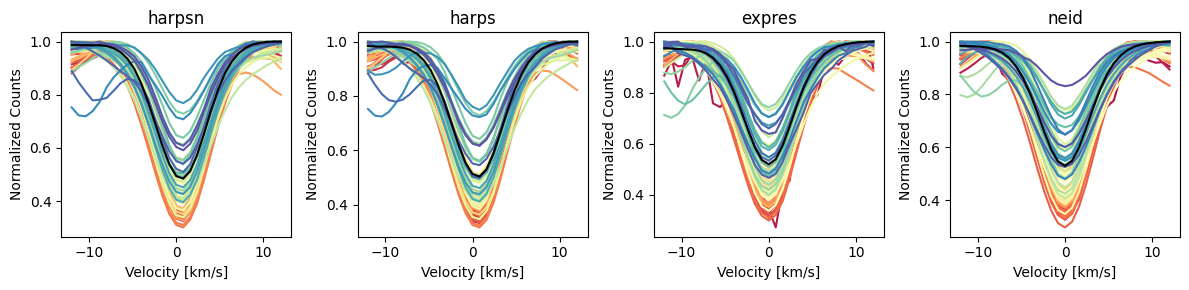

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(12,3))
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    ax = axes[iinst]
    ax.set_title(inst)
    ax.set_xlabel('Velocity [km/s]')
    ax.set_ylabel('Normalized Counts')
    # Select a random file
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','CCFs',f'DS{dset_num}*_{inst}.fits')))
    
    # Read in data
    ccf_dict = resampleCCF(file)
    num_ord = len(ccf_dict['echelle_orders']) # number of orders
    colors = sns.color_palette('Spectral',num_ord) # use that to define a color map
    v_grid = ccf_dict['v_grid'] # velocity grid for all CCFs in the file
    print(v_grid)
    ccf = ccf_dict['ccf']
    obo_ccf = ccf_dict['obo_ccf'] # obo CCFs
    
    # Plot Order-by-Order CCFs
    for nord in range(num_ord):
        if np.sum(np.isfinite(obo_ccf[nord]))==0:
            continue
        ax.plot(v_grid,obo_ccf[nord]/np.nanmax(obo_ccf[nord]),color=colors[nord])
    # Plot Summed/Average CCF
    ax.plot(v_grid,ccf/np.nanmax(ccf),color='k')
fig.tight_layout()



## Shift CCFs by Provided Offsets

In [7]:
def shiftCCF(ccf_x,ccf_y,rv):
    return interp1d(ccf_x-rv/1000,ccf_y,kind='cubic',bounds_error=False)(ccf_x)

In [9]:
# Read in offsets, which should be subtracted
offset_file = 'instrument_offsets_iccf.csv'
offset_dict = dict(zip(*np.loadtxt(offset_file),
                       delimiter=',',unpack=True,dtype=str))
offset_dict = {key:float(val) for key,val in offset_dict.items()}

FileNotFoundError: instrument_offsets_iccf.csv not found.

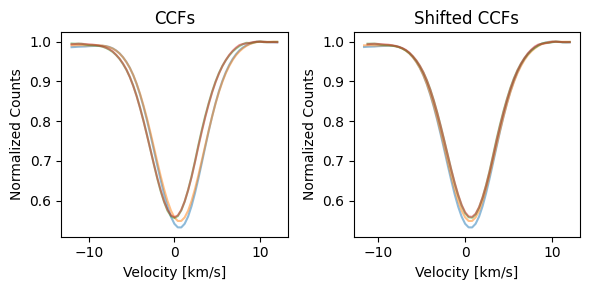

In [ ]:
# Plot Original CCFs and Shifted CCFs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,3))
ax1.set_title('CCFs')
ax2.set_title('Shifted CCFs')
for ax in [ax1,ax2]:
    ax.set_xlabel('Velocity [km/s]')
    ax.set_ylabel('Normalized Counts')
    
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    # Select a random file
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','CCFs',f'DS{dset_num}*_{inst}.fits')))
    
    # Read in data
    hdus = fits.open(file)
    v_grid = hdus['v_grid'].data.copy() # velocity grid for all CCFs in the file
    ccf = hdus['ccf'].data.copy()
    hdus.close()
    
    # Plot Summed/Average CCF
    ax1.plot(v_grid,ccf/np.nanmax(ccf),alpha=0.5)
    # Plot Shifted CCF
    ax2.plot(v_grid,shiftCCF(v_grid,ccf/np.nanmax(ccf),offset_dict[inst]),alpha=0.5)
fig.tight_layout()